<a href="https://colab.research.google.com/github/prasannashrestha011/ML_exercises/blob/main/CNN/colorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_io

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
datasets,info=tfds.load("caltech101",split=['train[:80%]','train[80%:]'],with_info=True)
train_dataset,val_dataset=datasets

In [3]:
print(info.description)

Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
`background clutter` class. Each image is labelled with a single object. Each
class contains roughly 40 to 800 images, totalling around 9k images. Images are
of variable sizes, with typical edge lengths of 200-300 pixels. This version
contains image-level labels only. The original dataset also contains bounding
boxes.


In [4]:
import tensorflow_io as tfio  # make sure to install with: !pip install tensorflow-io

def preprocess_sample_lab(sample):
    # Convert to float32 [0,1]
    image = tf.cast(sample['image'], tf.float32) / 255.0

    # Resize to 128x128
    image = tf.image.resize(image, [128, 128])

    # If 4 channels, keep only first 3
    image = tf.cond(tf.equal(tf.shape(image)[-1], 4),
                    lambda: image[:, :, :3],
                    lambda: image)

    # Convert RGB to LAB
    lab = tfio.experimental.color.rgb_to_lab(image)

    # Split channels
    L = lab[..., 0:1] /100.      # input grayscale
    ab = lab[..., 1:3]/128.      # target color channels

    return L, ab
train_dataset = train_dataset.map(preprocess_sample_lab, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_sample_lab, num_parallel_calls=tf.data.AUTOTUNE)

# Batch
BATCH_SIZE = 16
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Preprocessing done! Datasets ready for training (LAB).")


/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl7strings13safe_strtou64ESt17basic_string_viewIcSt11char_traitsIcEEPm']
  warnings.warn(

Preprocessing done! Datasets ready for training (LAB).


In [5]:
from tensorflow.keras import layers, models

input_layer = layers.Input(shape=(128,128,1))  # L channel

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)

output_layer = layers.Conv2D(2, (3,3), activation='tanh', padding='same')(x)  # 2 channels (ab)

model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 2)    │         2,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,010 (2.54 MB)

 Trainable params: 667,010 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
EPOCHS = 20  # start small for testing

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)


Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 129ms/step - loss: 0.0169 - val_loss: 0.0147
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0138 - val_loss: 0.0143
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 10/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0136 - val_loss: 0.0140
Epoch 11/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 12/20
153/153 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


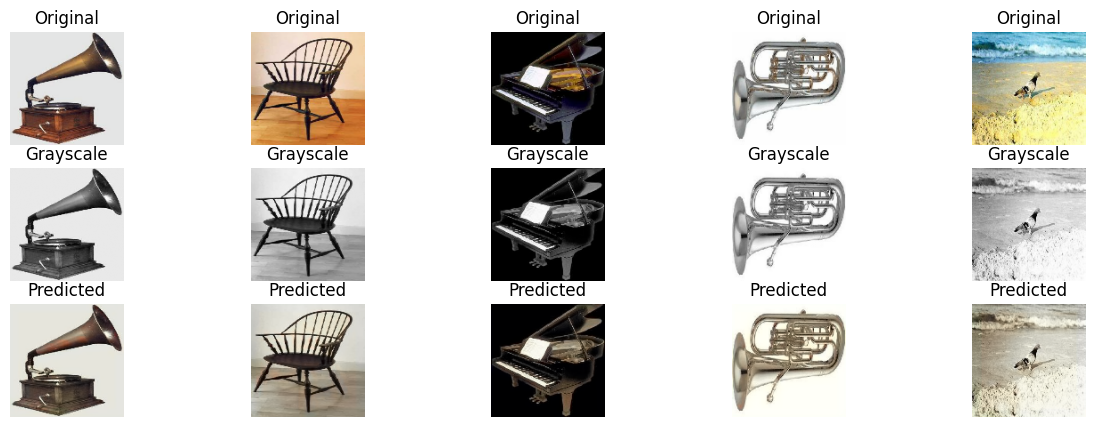

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio  # for LAB<->RGB conversion
import random

def show_random_predictions(model, val_dataset, num_images=5):
    """
    Predict and display random images from validation dataset.
    """
    # Convert dataset to list of batches
    val_batches = list(val_dataset)

    # Pick a random batch
    L_batch, ab_batch = random.choice(val_batches)

    # Predict ab channels
    pred_ab = model.predict(L_batch)

    # Rescale predicted ab and L to proper LAB ranges
    pred_ab = pred_ab * 128.0          # ab: [-1,1] → [-128,128]
    L_batch_scaled = L_batch * 100.0   # L: [0,1] → [0,100]

    # Combine L + predicted ab to LAB
    pred_lab = tf.concat([L_batch_scaled, pred_ab], axis=-1)

    # Convert LAB → RGB
    pred_rgb = tfio.experimental.color.lab_to_rgb(pred_lab)
    pred_rgb = tf.clip_by_value(pred_rgb, 0.0, 1.0)  # clip [0,1]

    # Convert original batch back to RGB for display
    ab_batch_rgb = tfio.experimental.color.lab_to_rgb(
        tf.concat([L_batch_scaled, ab_batch * 128.0], axis=-1)
    )
    ab_batch_rgb = tf.clip_by_value(ab_batch_rgb, 0.0, 1.0)

    # Convert tensors to uint8
    pred_rgb = (pred_rgb.numpy() * 255).astype('uint8')
    L_batch_gray = (L_batch.numpy() * 255).astype('uint8')
    ab_batch_rgb = (ab_batch_rgb.numpy() * 255).astype('uint8')

    # Pick random indices from batch
    indices = random.sample(range(L_batch.shape[0]), num_images)

    # Plot
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        # Original color
        plt.subplot(3, num_images, i+1)
        plt.imshow(ab_batch_rgb[idx])
        plt.title('Original')
        plt.axis('off')

        # Grayscale (L channel)
        plt.subplot(3, num_images, i+1+num_images)
        plt.imshow(L_batch_gray[idx, :, :, 0], cmap='gray')
        plt.title('Grayscale')
        plt.axis('off')

        # Predicted color
        plt.subplot(3, num_images, i+1+2*num_images)
        plt.imshow(pred_rgb[idx])
        plt.title('Predicted')
        plt.axis('off')

    plt.show()


# Example usage
show_random_predictions(model, val_dataset, num_images=5)
